# Lista 2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

## zad 1

W pierwszym zadaniu generuję syntetyczny zbiór danych z trzema wyraźnie oddzielonymi skupieniami używając funkcji `make_blobs` z biblioteki `scikit-learn`. Definiuję liczbę klastrów oraz wartość seed dla zapewnienia powtarzalności wyników.


In [2]:
k = 3
random_state = 222

Przy okazji chciał"ym zbadać wpływ parametru `cluster_std` na rozrzut danych per klaster, testuję więc różne wartości odchylenia standardoweg.

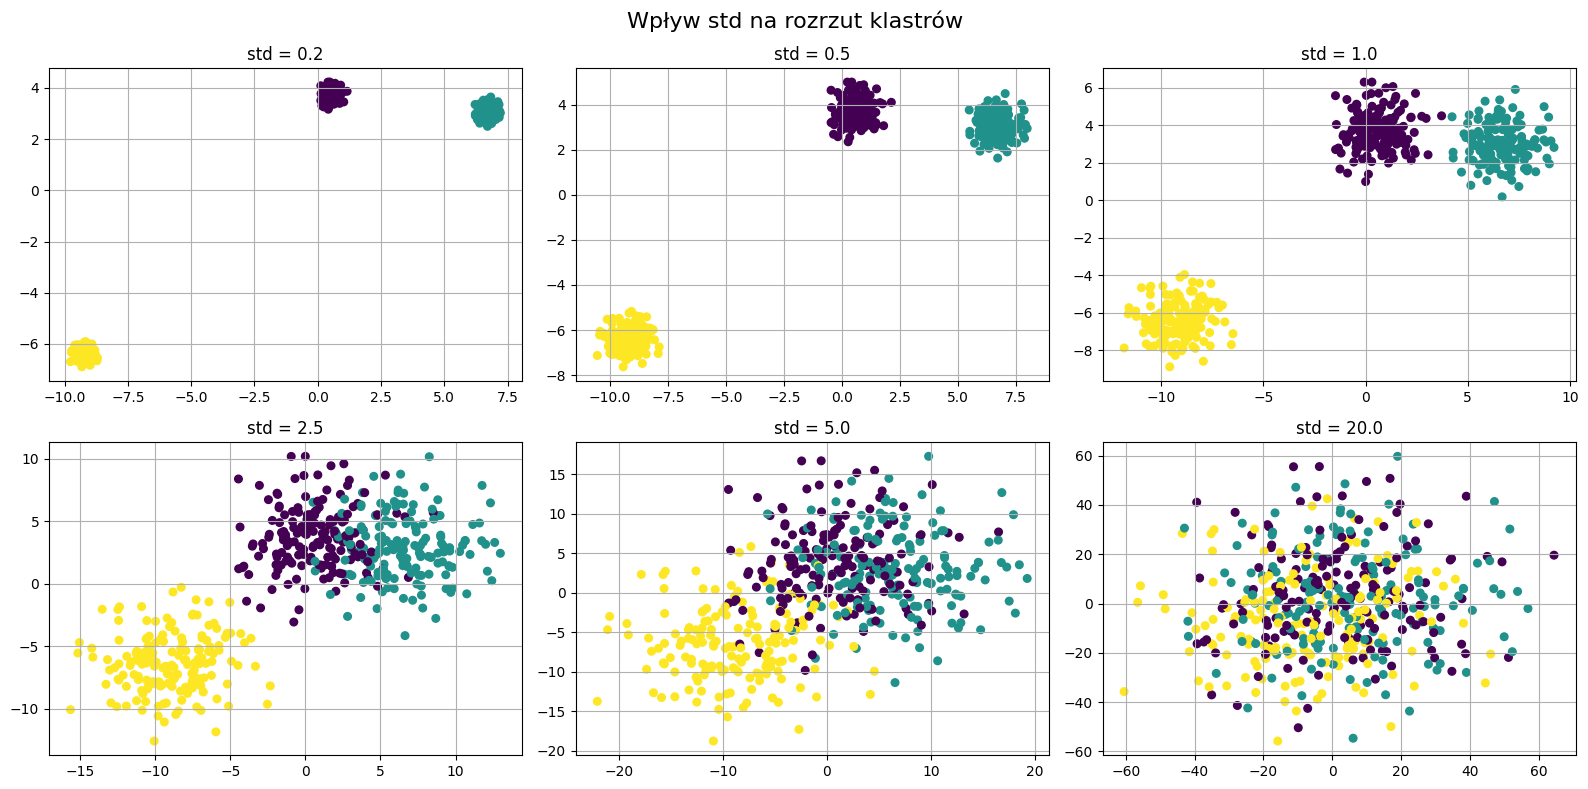

In [3]:
std_values = [0.2, 0.5, 1.0, 2.5, 5.0, 20.0]

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, std in enumerate(std_values):
    X, y = make_blobs(n_samples=500, centers=k, cluster_std=std, random_state=random_state)
    
    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30)
    ax.set_title(f'std = {std}')
    ax.grid(True)

plt.suptitle('Wpływ std na rozrzut klastrów', fontsize=16)
plt.tight_layout()
plt.show()


Na wykresach można zaobserwować, jak ze wzrostem wartości `std` klastry stają się bardziej rozproszone i trudniejsze do rozdzielenia.

## zad 2

Implementuję algorytm k-means od podstaw, bez użycia gotowych rozwiązań z scikit-learn. Moja implementacja opiera się na algorytmie Lloyda z wykładu:

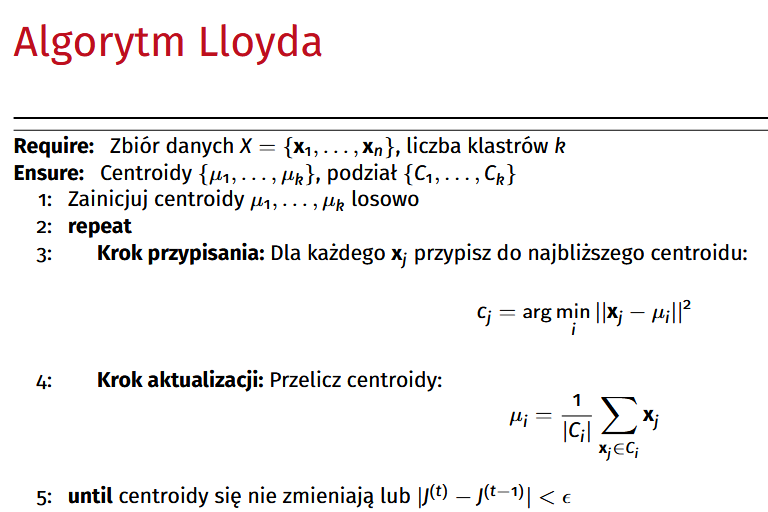

In [4]:
def get_centroids(X, k):
    np.random.seed(random_state)

    # 1. Zainicjaluj centroidy mi_1, ..., mi_k losowo
    indices = np.random.choice(len(X), k, replace=False)
    centroids = X[indices]

    # 2. repeat
    while True:
        # 3. krok przypisania
        d = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        cj = np.argmin(d, axis=1)

        # 4. krok aktualizacji
        new_centroids = np.array([X[cj == i].mean(axis=0) for i in range(k)])

        # 5. until
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroids

Tak przygotowany algorytm testuje na identycznych danych co w zadaniu 1

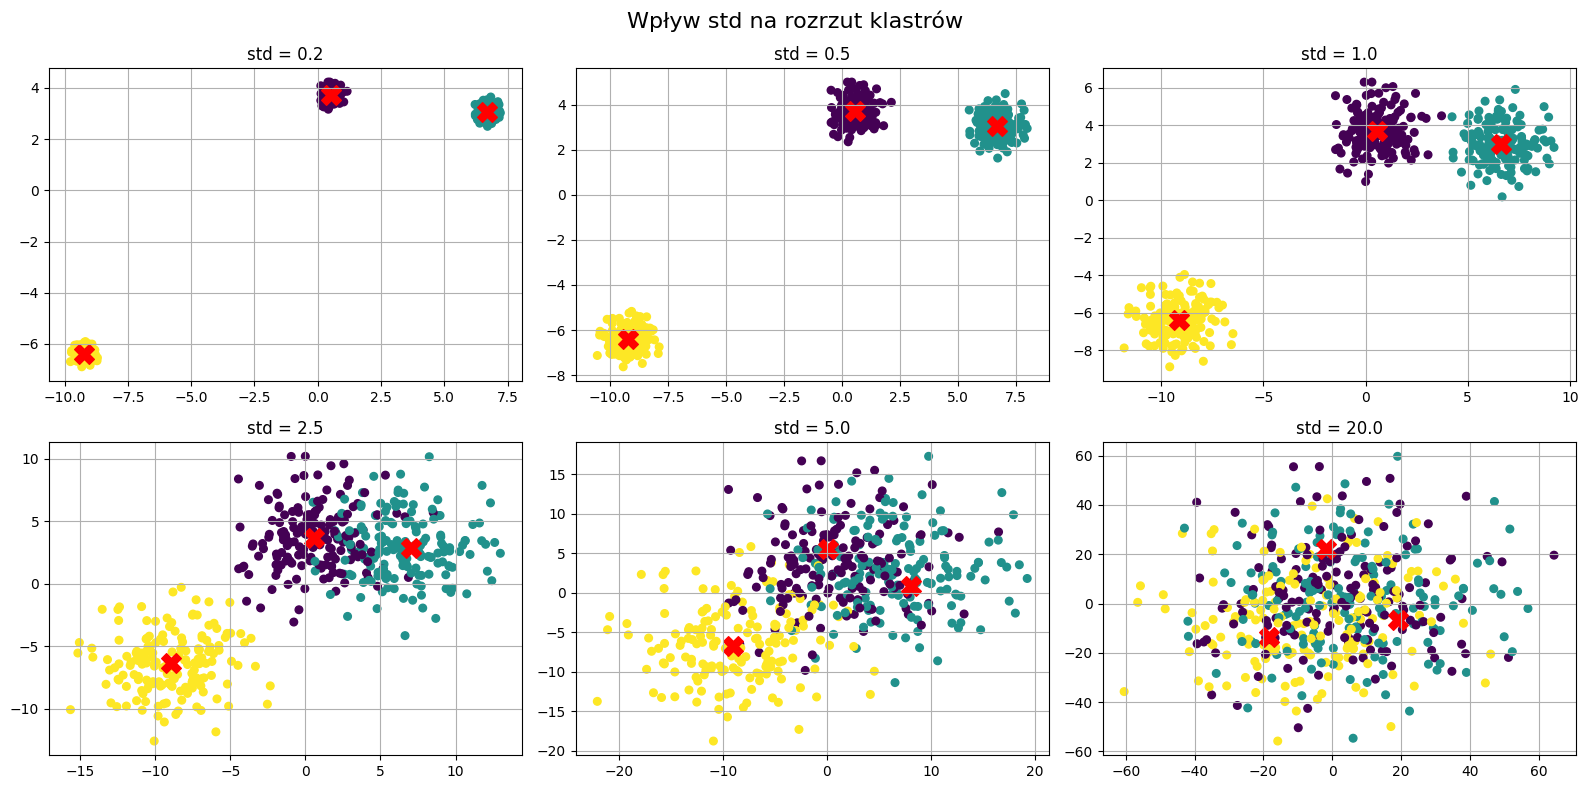

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i, std in enumerate(std_values):
    X, y = make_blobs(n_samples=500, centers=k, cluster_std=std, random_state=random_state)
    
    centroids = get_centroids(X, k)
    
    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='X', label='Centroidy')
    ax.set_title(f'std = {std}')
    ax.grid(True)

plt.suptitle('Wpływ std na rozrzut klastrów', fontsize=16)
plt.tight_layout()
plt.show()

Algorytm wydaje się działać w porządku, teraz w zadaniu 3 porównam go z wbudowanych w bibliotekę.

## zad 3

W trzecim zadaniu wykorzystuję gotową implementację algorytmu k-means z biblioteki scikit-learn (klasa `KMeans`). Porównuję wyniki z moją własną implementacją z zadania 2.


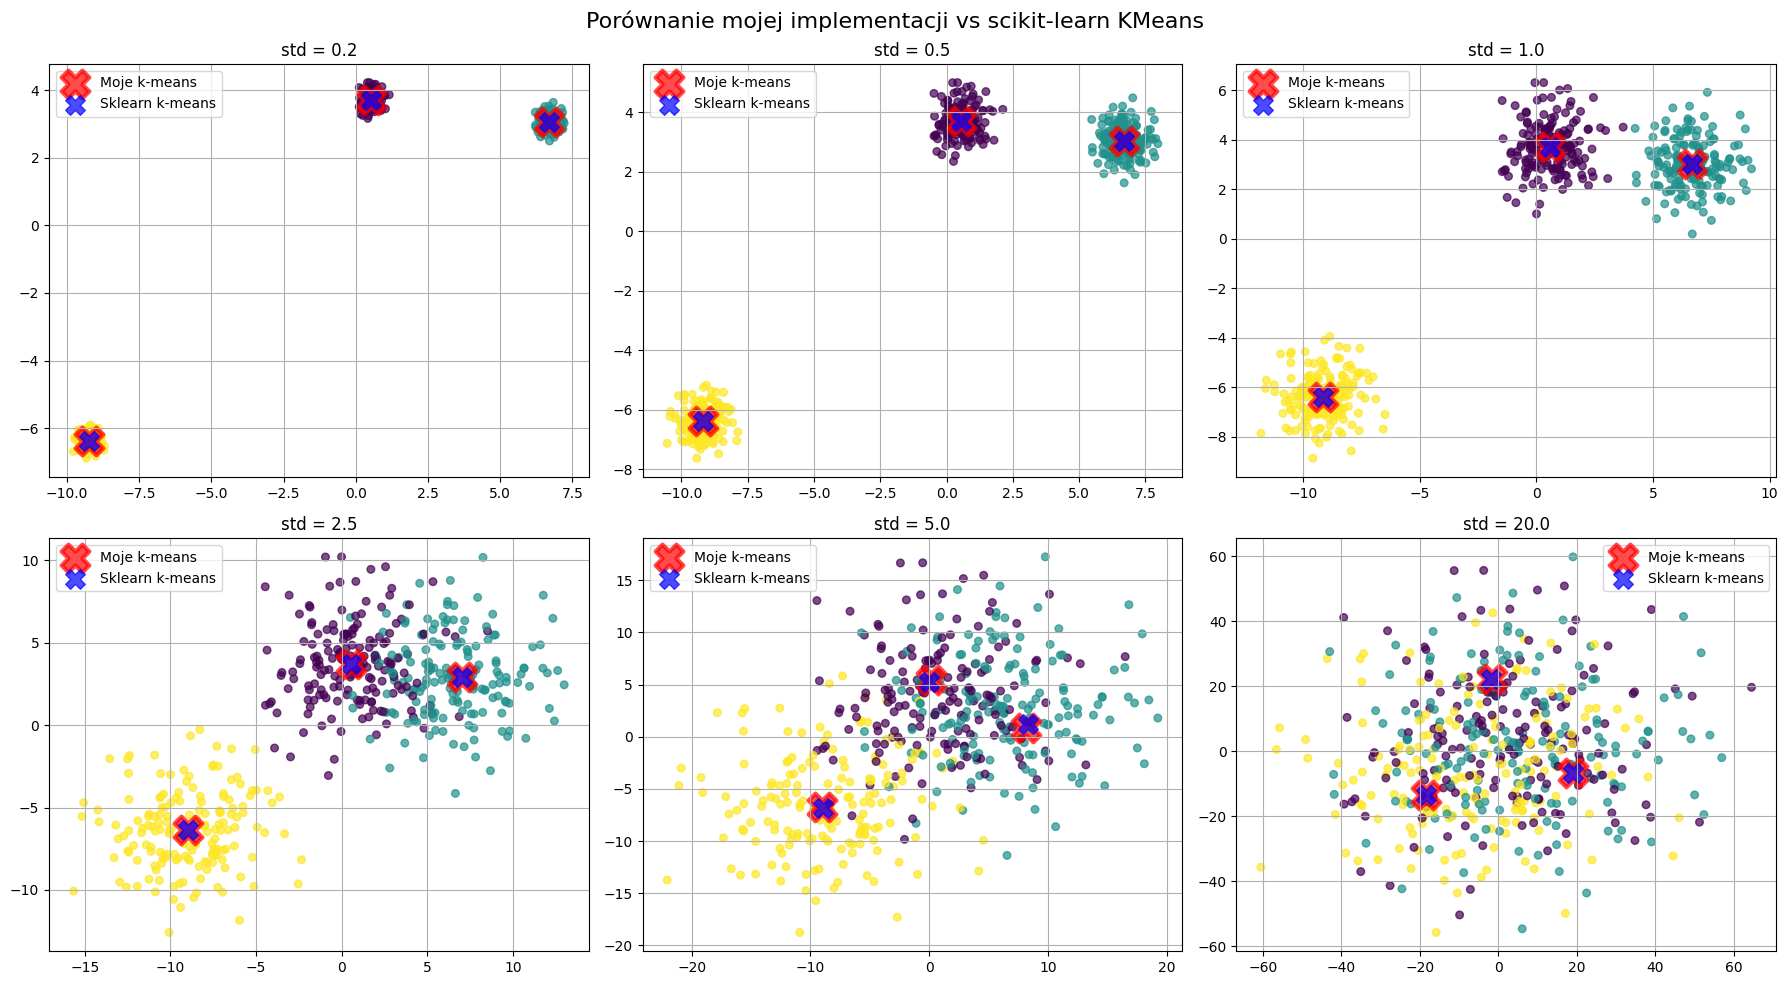

,Odchylenie std,Różnica R²
0,0.2,8.736635e-29
1,0.5,2.150879e-29
2,1.0,1.983246e-29
3,2.5,8.572916e+01
4,5.0,7.151015e+02
5,20.0,3.074322e+03


In [6]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

differences = []

for i, std in enumerate(std_values):
    X, y = make_blobs(n_samples=500, centers=k, cluster_std=std, random_state=random_state)
    
    # moja
    my_centroids = get_centroids(X, k)
    
    # wbudowana
    kmeans_sklearn = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans_labels = kmeans_sklearn.fit_predict(X)
    
    ax = axes[i]
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=30, alpha=0.7)
    ax.scatter(my_centroids[:, 0], my_centroids[:, 1], c='red', s=400, marker='X', label='Moje k-means', linewidth=3, alpha=0.7)
    ax.scatter(kmeans_sklearn.cluster_centers_[:, 0], kmeans_sklearn.cluster_centers_[:, 1], c='blue', s=200, marker='X', label='Sklearn k-means', linewidth=1, alpha=0.7)
    
    ax.set_title(f'std = {std}')
    ax.grid(True)
    ax.legend()
    
    diff_squared = np.sum((my_centroids - kmeans_sklearn.cluster_centers_)**2)
    differences.append(diff_squared)

plt.suptitle('Porównanie mojej implementacji vs scikit-learn KMeans', fontsize=16)
plt.tight_layout()
plt.show()

pd.DataFrame({
    'Odchylenie std': std_values,
    'Różnica R²': differences
})

## zad 4

Teraz w czwartym zadaniu zastosuję algorytm klastrowania hierarchicznego (`AgglomerativeClustering`) ponownie na tych samych d anych z zadania 1. Przetestuję różne miary odległości. Celem jest sprawdzenie, jak wybór miary odległości wpływa na strukturę skupień i jakość klastrowania.


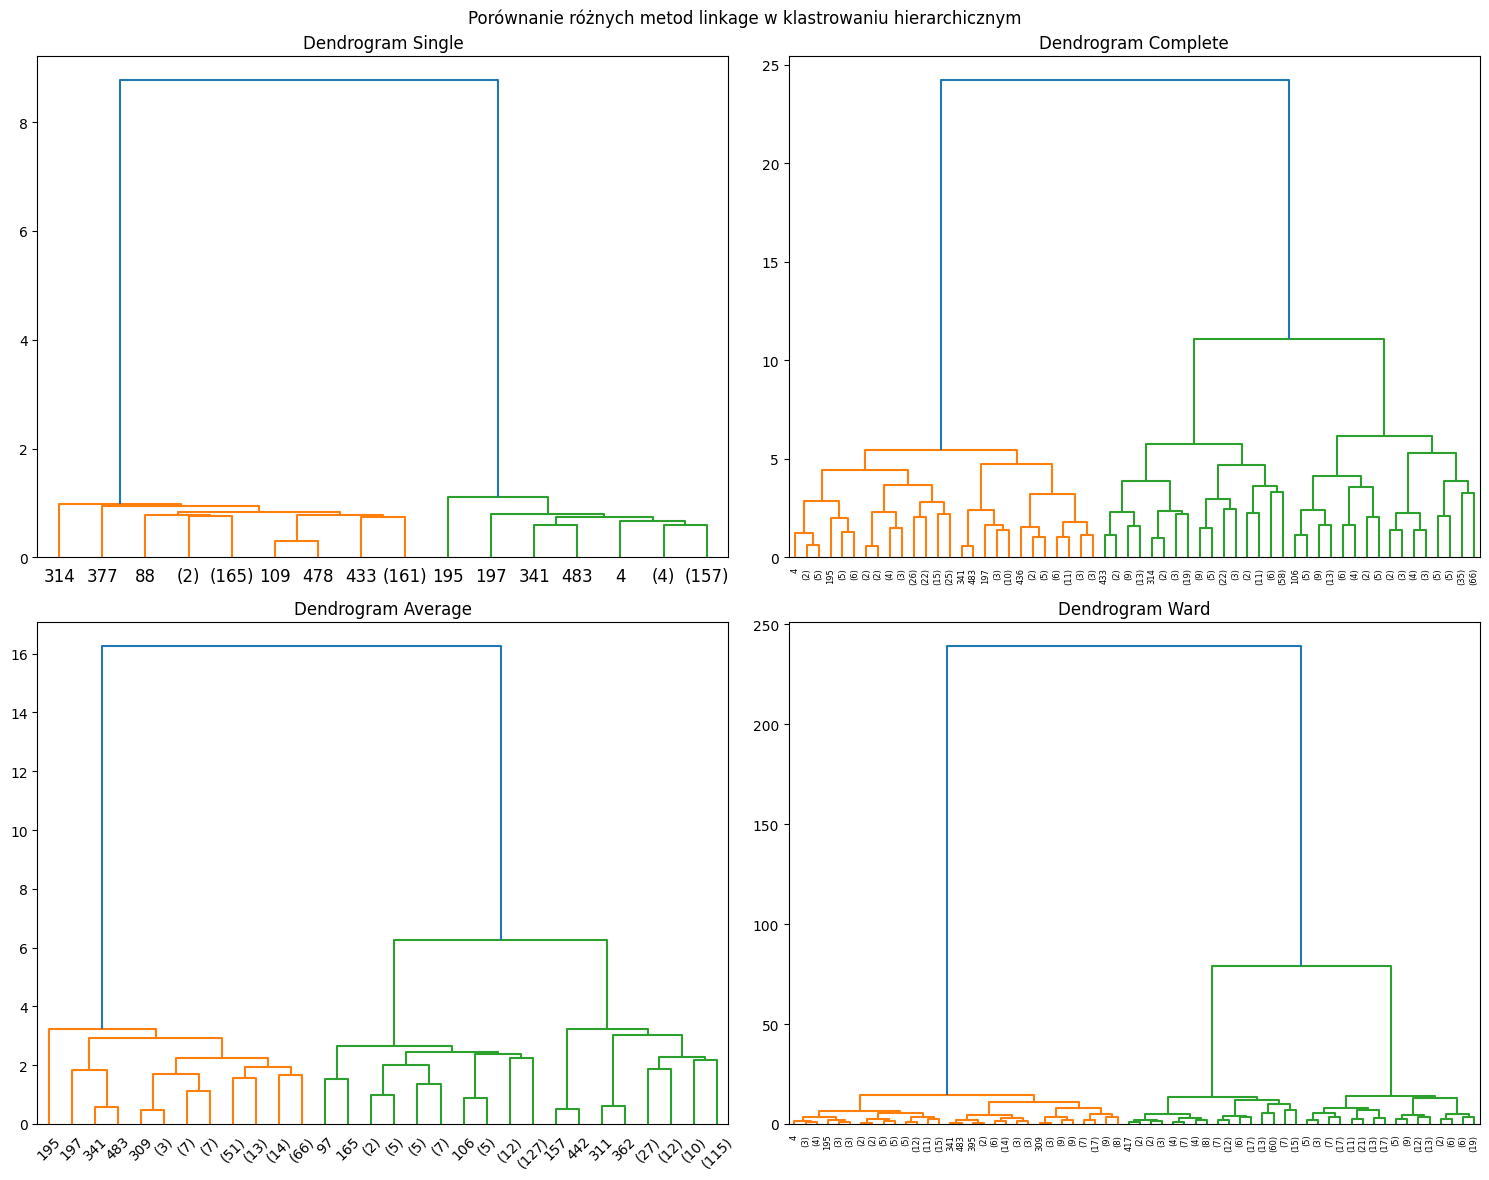

In [7]:
X_hierarchical, y_hierarchical = make_blobs(n_samples=500, centers=k, cluster_std=1.0, random_state=random_state)
linkage_methods = ['single', 'complete', 'average', 'ward']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, method in enumerate(linkage_methods):
    ax = axes[i]
    
    if method == 'ward':
        Z = linkage(X_hierarchical, method=method)
    else:
        Z = linkage(X_hierarchical, method=method, metric='euclidean')
    
    dendrogram(Z, ax=ax, truncate_mode='level', p=5)
    ax.set_title(f'Dendrogram {method.capitalize()}')

plt.suptitle('Porównanie różnych metod linkage w klastrowaniu hierarchicznym')
plt.tight_layout()
plt.show()

Dendrogramy wyraźnie pokazują różnice w strukturze hierarchicznej w zależności od metody linkage:

- **Single linkage** - długie połączenia na niskich odległościach
- **Complete linkage** - tworzy bardziej zbalansowaną strukturę z połączeniami na wyższych odległościach
- **Average linkage** - bardzo podobnie do `complete`
- **Ward linkage** - połączenia najniższe


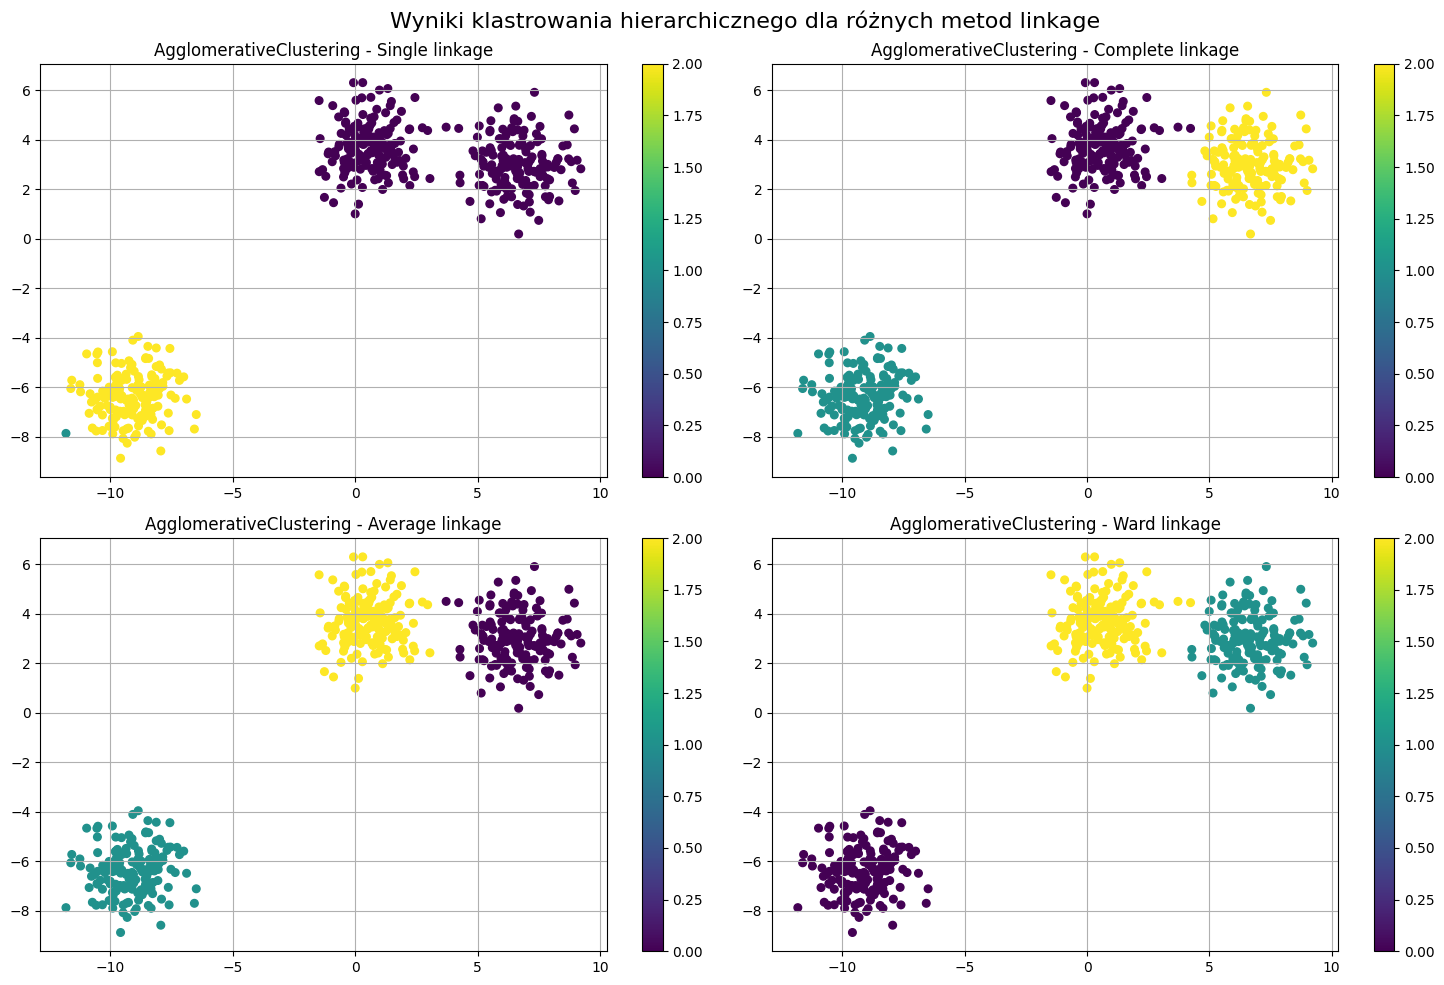

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, method in enumerate(linkage_methods):
    clustering = AgglomerativeClustering(n_clusters=k, linkage=method)
    cluster_labels = clustering.fit_predict(X_hierarchical)
    
    ax = axes[i]
    scatter = ax.scatter(X_hierarchical[:, 0], X_hierarchical[:, 1], c=cluster_labels, cmap='viridis', s=30)
    ax.set_title(f'AgglomerativeClustering - {method.capitalize()} linkage')
    ax.grid(True)
    plt.colorbar(scatter, ax=ax)

plt.suptitle('Wyniki klastrowania hierarchicznego dla różnych metod linkage', fontsize=16)
plt.tight_layout()
plt.show()

Porównanie wizualne potwierdza różnice w jakości klastrowania:

- **Single linkage** - niepoprawnie łączy dwa górne skupienia w jeden duży klaster
- **Complete linkage** - skutecznie rozdziela wszystkie trzy naturalne skupienia na odrębne klastry
- **Average linkage** - tak jak wyzej, b. dobry
- **Ward linkage** - tak jak wyżej, b. dobry


In [9]:
for method in linkage_methods:
    clustering = AgglomerativeClustering(n_clusters=k, linkage=method)
    cluster_labels = clustering.fit_predict(X_hierarchical)
    
    intra_cluster_distances = []
    for cluster_id in range(k):
        cluster_points = X_hierarchical[cluster_labels == cluster_id]
        if len(cluster_points) > 1:
            distances = pdist(cluster_points)
            intra_cluster_distances.append(np.mean(distances))
        else:
            intra_cluster_distances.append(0)
    
    print(f"\n{method.capitalize()} linkage:")
    print(f"- Średnia odległość wewnątrz klastrów: {np.mean(intra_cluster_distances):.2f}")
    print(f"- Liczba punktów w klastrach: {[np.sum(cluster_labels == i) for i in range(k)]}")
    print(f"- Odchylenie standardowe rozmiarów klastrów: {np.std([np.sum(cluster_labels == i) for i in range(k)]):.2f}")


Single linkage:
- Średnia odległość wewnątrz klastrów: 1.92
- Liczba punktów w klastrach: [np.int64(334), np.int64(1), np.int64(165)]
- Odchylenie standardowe rozmiarów klastrów: 135.95

Complete linkage:
- Średnia odległość wewnątrz klastrów: 1.77
- Liczba punktów w klastrach: [np.int64(168), np.int64(166), np.int64(166)]
- Odchylenie standardowe rozmiarów klastrów: 0.94

Average linkage:
- Średnia odległość wewnątrz klastrów: 1.77
- Liczba punktów w klastrach: [np.int64(168), np.int64(166), np.int64(166)]
- Odchylenie standardowe rozmiarów klastrów: 0.94

Ward linkage:
- Średnia odległość wewnątrz klastrów: 1.77
- Liczba punktów w klastrach: [np.int64(166), np.int64(166), np.int64(168)]
- Odchylenie standardowe rozmiarów klastrów: 0.94


Dla naszego zestawu danych tylko sposób `single linkage` wydaje się nieodpowiedni.

## zad 5

W piątym zadaniu przechodzę już do nowego zbioru danych, znanego z listy 1 - `Iris`

Przetestuję wobec niego dwie metody oceny jakości klastrowania:
1. **Metoda łokcia (Elbow Method)**

<img src="./screens/l2-elbow.png" style="width: 45%;">
<br>

2. **Wskaźnik Silhouette**

<img src="./screens/l2-silhouette.png" style="width: 45%;">
<br>

Implementacja obu metod pochodzi z udostępnionych "Kody do wykłądu 3"

In [10]:
def elbow_method(X, max_k=10):
    sse = []
    k_range = range(1, max_k + 1)
    for k in k_range:
        if k == 1:
            sse.append(np.sum((X - X.mean(axis=0))**2))
        else:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(X)
            sse.append(kmeans.inertia_)
    return k_range, sse


In [11]:
def silhouette_analysis(X, max_k=10):
    silhouette_scores = []
    k_range = range(2, max_k + 1) # Silhouette requires at least 2 clusters
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)
    return k_range, silhouette_scores

Rozpoczynam od wczytania danych `Iris`

In [12]:
iris = load_iris()
X = iris.data
y_true = iris.target

print(f"Zbiór danych Iris: X={X.shape[0]}, y={X.shape[1]}")
print(f"Liczba klas: {len(np.unique(y_true))}")

Zbiór danych Iris: X=150, y=4
Liczba klas: 3


Gdy już posiadam dane oraz metody dokonuje właściwej analizy, również na bazie kodów z wykładu.

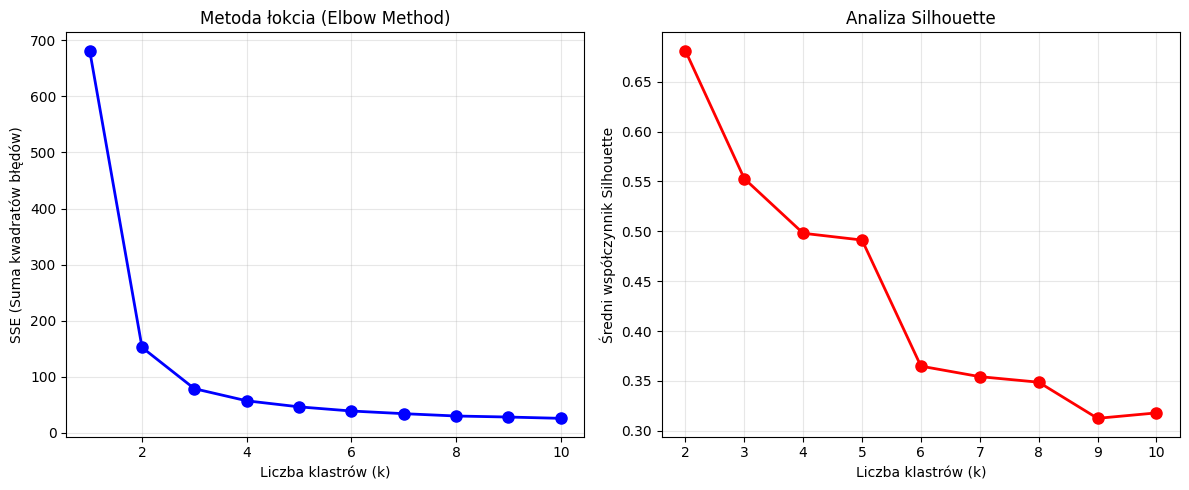

In [13]:
k_range, sse = elbow_method(X, max_k=10)
k_range_sil, silhouette_scores = silhouette_analysis(X, max_k=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, sse, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Liczba klastrów (k)')
ax1.set_ylabel('SSE (Suma kwadratów błędów)')
ax1.set_title('Metoda łokcia (Elbow Method)')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range_sil, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Liczba klastrów (k)')
ax2.set_ylabel('Średni współczynnik Silhouette')
ax2.set_title('Analiza Silhouette')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Metoda łokcia wskazuje na k=3 jako punkt optymalny. Jednak **analiza Silhouette** wskazuje na **k=2**, co sugeruje, że dane najlepiej dzielą się na dwa wyraźne skupienia.

**Wniosek:** Chociaż prawdziwa liczba klas w Iris to 3, analiza Silhouette sugeruje, że dane mają naturalną tendencję do grupowania się w 2 główne skupienia, co może wynikać z podobieństwa niektórych gatunków irysów.

Zaciekawiony tym tematem znalazłem czyjąć analizę pod `k=2` (<a href="https://www.kaggle.com/code/meran2k/clustering-evaluation-of-iris-dataset">link</a>).

<center>
    <img src="./screens/l2-irish-k2.png" style="width: 45%; margin-right: 5%;">
    <img src="./screens/l2-irish-k3.png" style="width: 45%;">
</center>

Rzeczywiście patrząc z boku podział na 2 (niespójny z rzeczywistością) wydaje się mieć sens. Jest to pewien wniosek przy klastrowaniu, że łatwo się nabrać.

## zad 6

Wracam do zestawu danych z zad 1., aby przetestować inny algorytm klasteryzacji - `DBSCAN`. Podczas testówp rzetestuję różne wartości parametrów:
- **eps** - maksymalna odległość między dwoma punktami, aby jeden był w sąsiedztwie drugiego
- **min_samples** - minimalna liczba punktów w sąsiedztwie punktu, aby uznać go za punkt rdzeniowy

Zaobserwuję jak te parametry wpływają na wyniki klastrowania i zidentyfikuję punkty odstające (szum) w danych.

<center>
<img src="./screens/l2-dbscan1.png" style="width: 75%;">
</center>

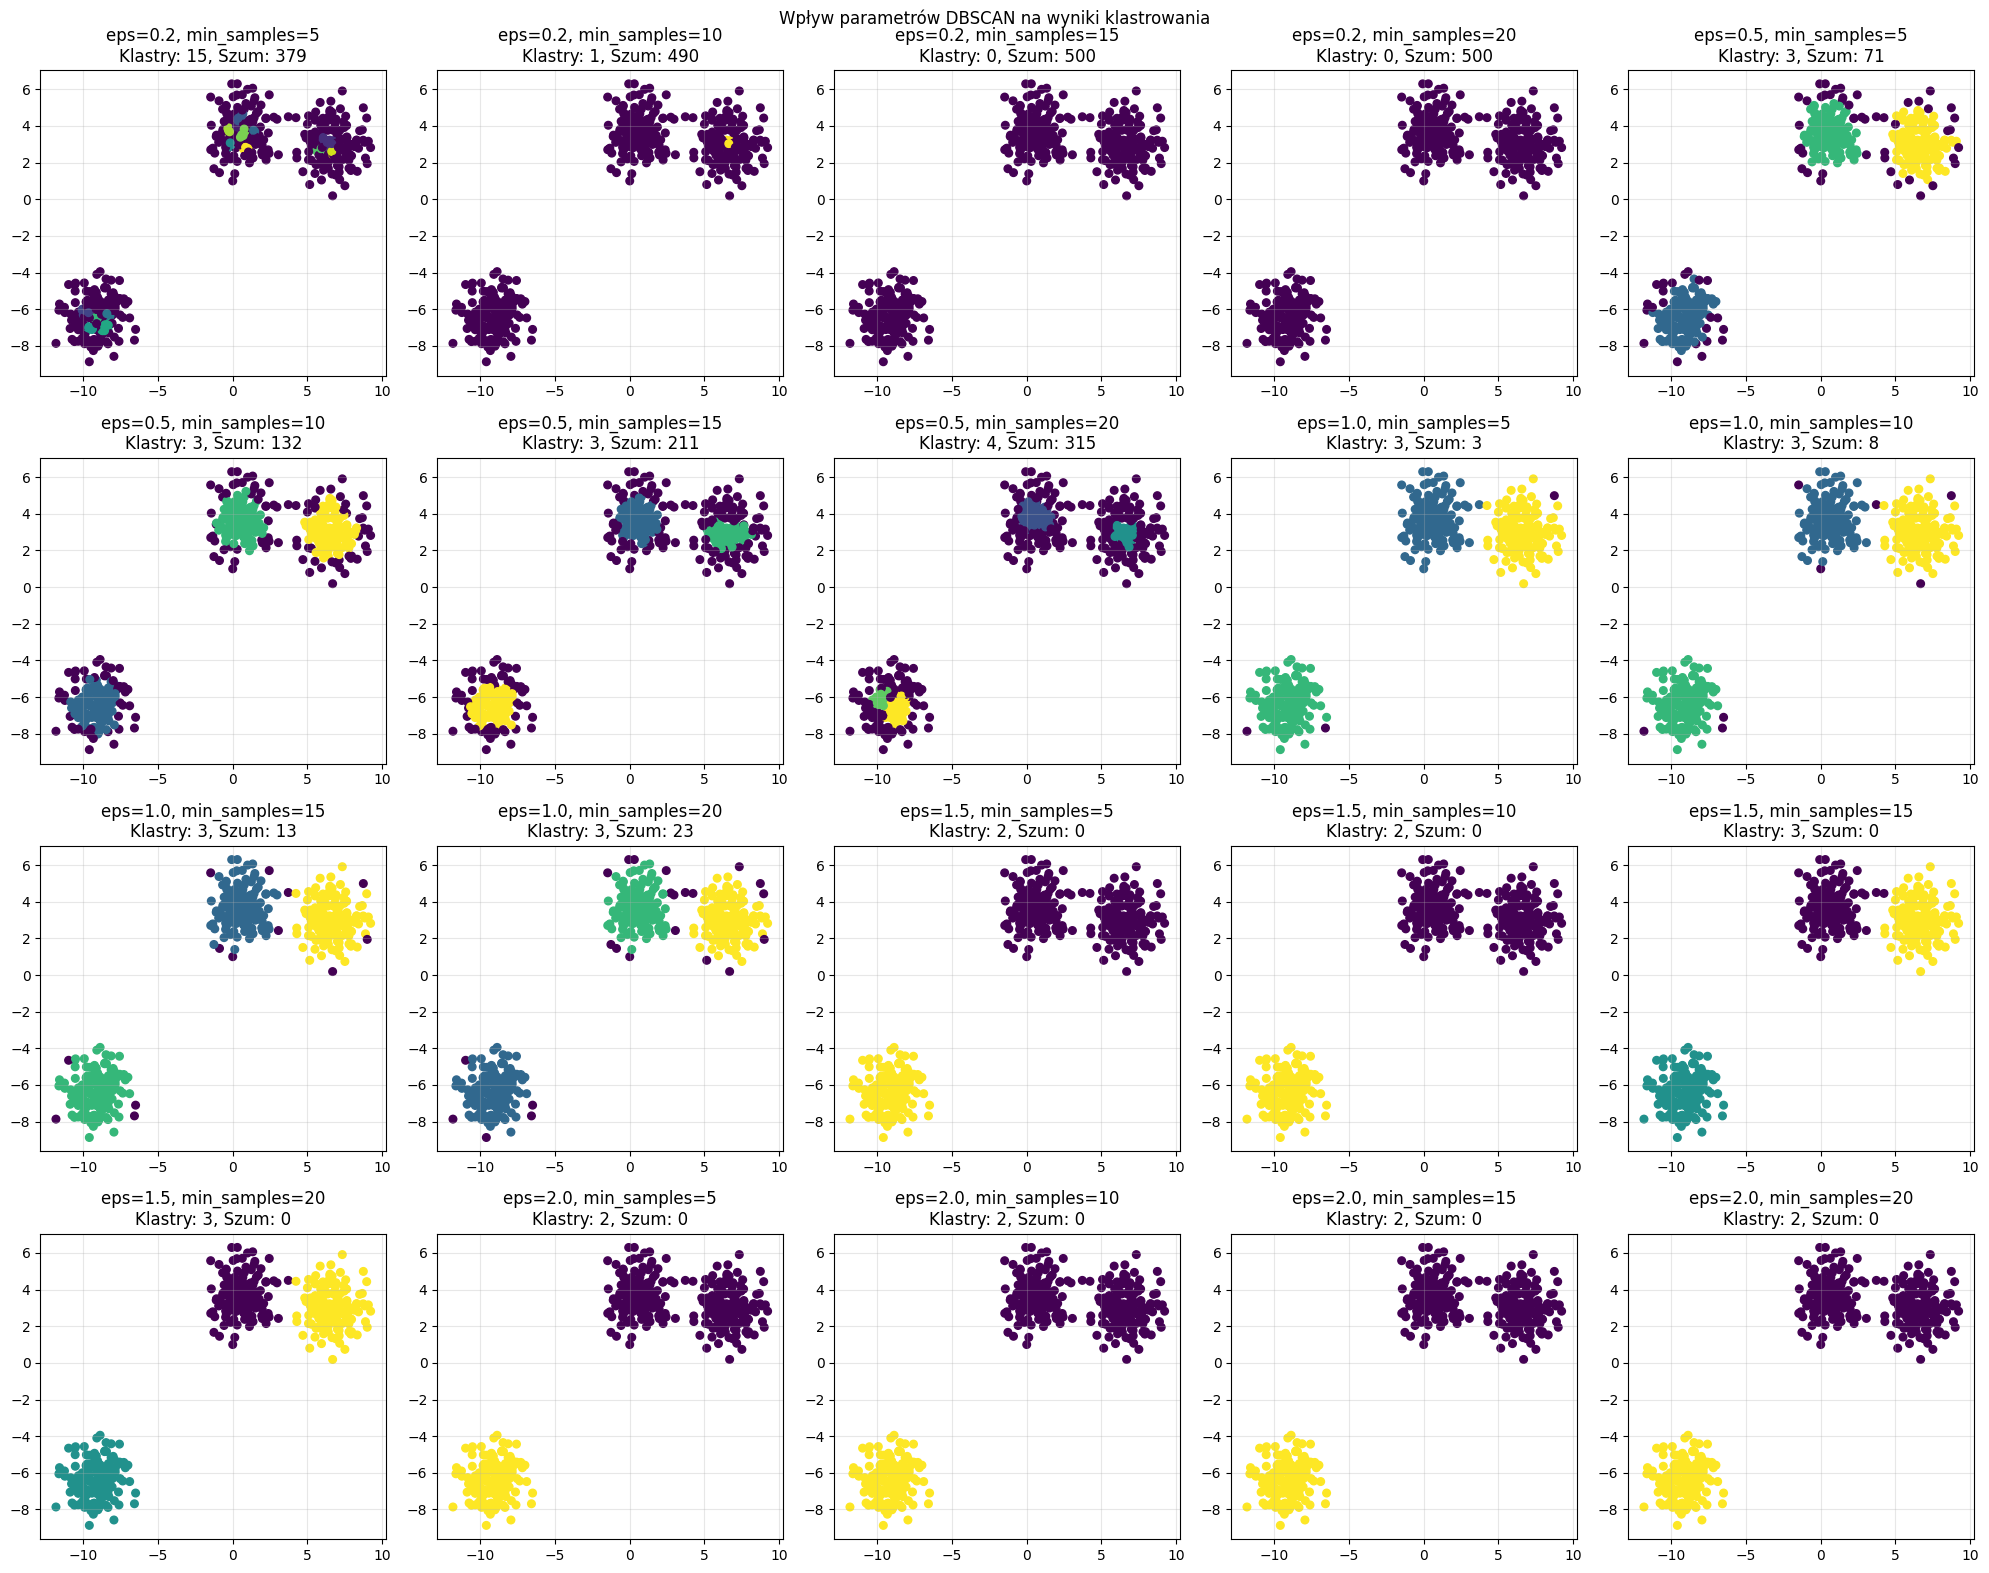

In [14]:
X_dbscan, y_dbscan = make_blobs(n_samples=500, centers=k, cluster_std=1.0, random_state=random_state)

eps_values = [0.2, 0.5, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 15, 20]

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.flatten()

plot_idx = 0
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X_dbscan)
        
        ax = axes[plot_idx]
        scatter = ax.scatter(X_dbscan[:, 0], X_dbscan[:, 1], c=dbscan_labels, cmap='viridis', s=30)
        
        n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)
        
        ax.set_title(f'eps={eps}, min_samples={min_samples}\nKlastry: {n_clusters}, Szum: {n_noise}')
        ax.grid(True, alpha=0.3)
        
        plot_idx += 1

plt.suptitle('Wpływ parametrów DBSCAN na wyniki klastrowania')
plt.tight_layout()
plt.show()

wpływ parametru `eps`:
- **Zbyt małe eps**: generuje wiele małych klastrów
- **Optymalne eps**: pozwala na skuteczne wykrycie naturalnych trzech klastrów z minimalnym szumem
- **Zbyt duże eps**: łączy naturalnie oddzielone klastry w jeden

wpływ parametru `min_samples`:
- **Dla małego eps**: zwiększanie min_samples drastycznie zwiększa szum i zmniejsza liczbę klastrów
- **Dla optymalnego eps**: wyższe min_samples stopniowo zwiększa szum, ale utrzymuje strukturę klastrów
- **Dla dużego eps**: odpowiednio wysokie min_samples może zapobiec niepożądanemu łączeniu klastrów

DBSCAN jest bardzo wrażliwy na parametry

## zad 7

W ostatnim zadaniu przeprowadzam analizę skupień na rzeczywistym zbiorze danych dotyczącym klientów (Mall Customer Segmentation Data). Analiza obejmuje wczytanie danych, eksplorację, wybór cech, zastosowanie k-means i interpretację wyników segmentacji klientów.

W ostatnim zadaniu wykorzystam zb→iór danych `Mall Customer Segmentation Data` z Kaggle, aby przeprowadzić analizę skupień na czymś realniejszym.
1. Wczytanie i przegląd danych
2. Wybór odpowiednich cech do analizy (np. wiek i roczny dochód)
3. Zastosowanie algorytmu k-means do segmentacji klientów
4. Wizualizację otrzymanych segmentów
5. Interpretację wyników i charakterystykę poszczególnych grup klientów

Wyniki (mam nadzieję) pozwolą zidentyfikować różne profile klientów, co może być przydatne w działaniach marketingowych i biznesowych


In [15]:
df_clients = pd.read_csv('assets/Mall_Customers.csv')
df_clients.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


Przeanalizuję rozkład kluczowych cech klientów - wieku i rocznego dochodu, które będą używane do segmentacji. Sprawdzę również rozkład płci i ocenę wydatków.


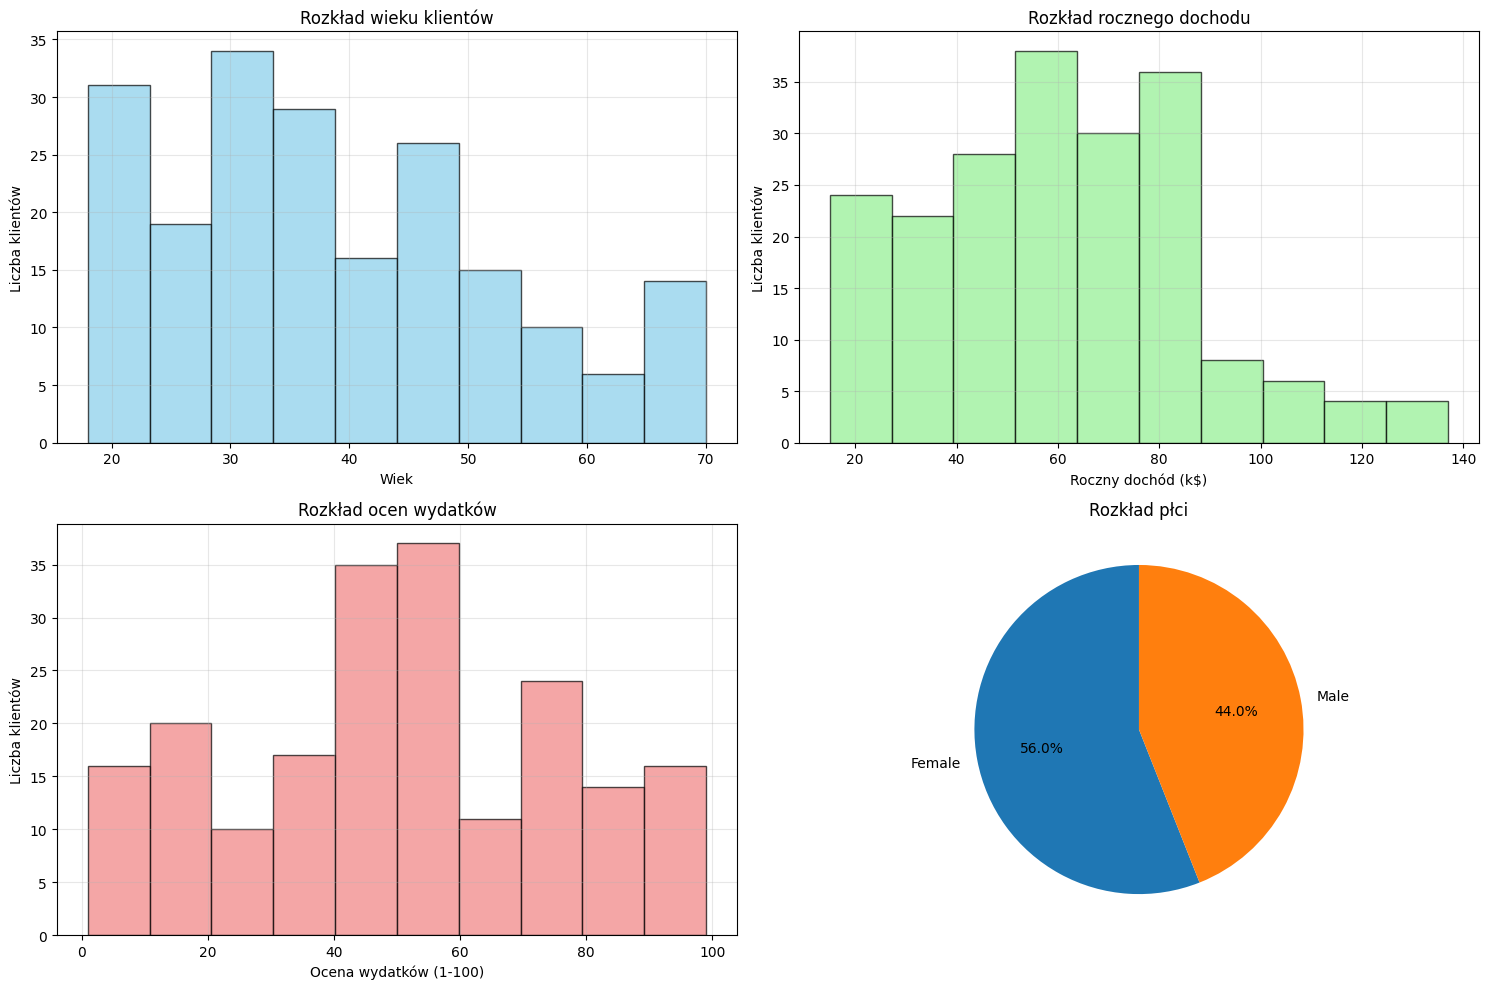

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].hist(df_clients['Age'], bins=10, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Rozkład wieku klientów')
axes[0, 0].set_xlabel('Wiek')
axes[0, 0].set_ylabel('Liczba klientów')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(df_clients['Annual Income (k$)'], bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Rozkład rocznego dochodu')
axes[0, 1].set_xlabel('Roczny dochód (k$)')
axes[0, 1].set_ylabel('Liczba klientów')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].hist(df_clients['Spending Score (1-100)'], bins=10, alpha=0.7, color='lightcoral', edgecolor='black')
axes[1, 0].set_title('Rozkład ocen wydatków')
axes[1, 0].set_xlabel('Ocena wydatków (1-100)')
axes[1, 0].set_ylabel('Liczba klientów')
axes[1, 0].grid(True, alpha=0.3)

gender_counts = df_clients['Gender'].value_counts()
axes[1, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Rozkład płci')

plt.tight_layout()
plt.show()

Korelacje

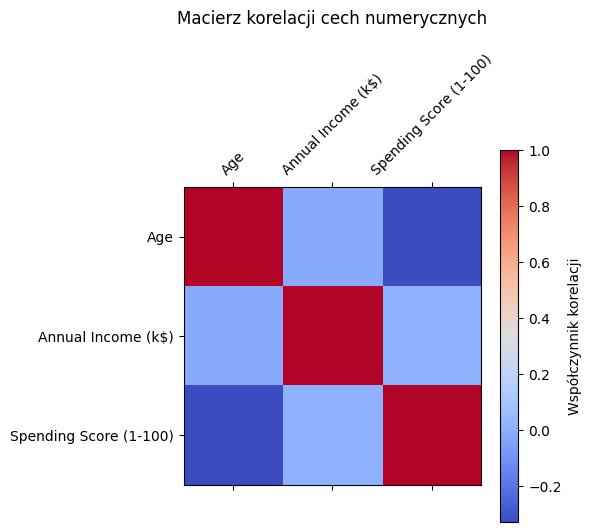

In [17]:
corr = df_clients[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()

plt.matshow(corr, cmap='coolwarm')
plt.title('Macierz korelacji cech numerycznych', pad=20)
plt.colorbar(label='Współczynnik korelacji')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.show()

Wybieram cechy wieku i rocznego dochodu do segmentacji klientów. Dane zostaną znormalizowane, aby zapewnić równe znaczenie obu cech w procesie klastrowania.


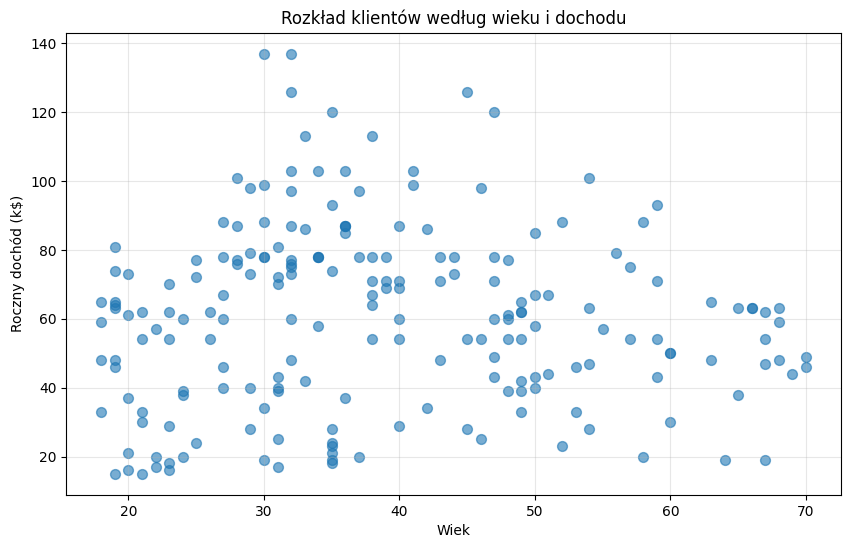

In [18]:
X_features = df_clients[['Age', 'Annual Income (k$)']].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

plt.figure(figsize=(10, 6))
plt.scatter(X_features[:, 0], X_features[:, 1], alpha=0.6, s=50)
plt.xlabel('Wiek')
plt.ylabel('Roczny dochód (k$)')
plt.title('Rozkład klientów według wieku i dochodu')
plt.grid(True, alpha=0.3)
plt.show()


Zastosuję metodę łokcia i analizę Silhouette, aby określić optymalną liczbę segmentów klientów.


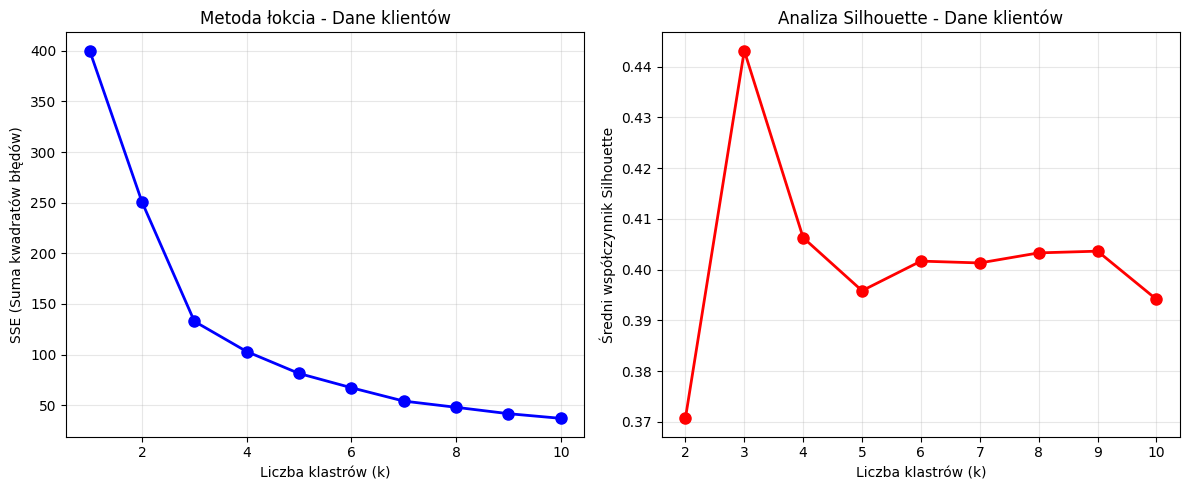

In [19]:
k_range, sse = elbow_method(X_scaled, max_k=10)
k_range_sil, silhouette_scores = silhouette_analysis(X_scaled, max_k=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, sse, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Liczba klastrów (k)')
ax1.set_ylabel('SSE (Suma kwadratów błędów)')
ax1.set_title('Metoda łokcia - Dane klientów')
ax1.grid(True, alpha=0.3)

ax2.plot(k_range_sil, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Liczba klastrów (k)')
ax2.set_ylabel('Średni współczynnik Silhouette')
ax2.set_title('Analiza Silhouette - Dane klientów')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

k=3 wedle obu metod.

Zatem użyje tak wyznaczonego k razem z algorytmem k-means żeby dokonać klasteryzacji.

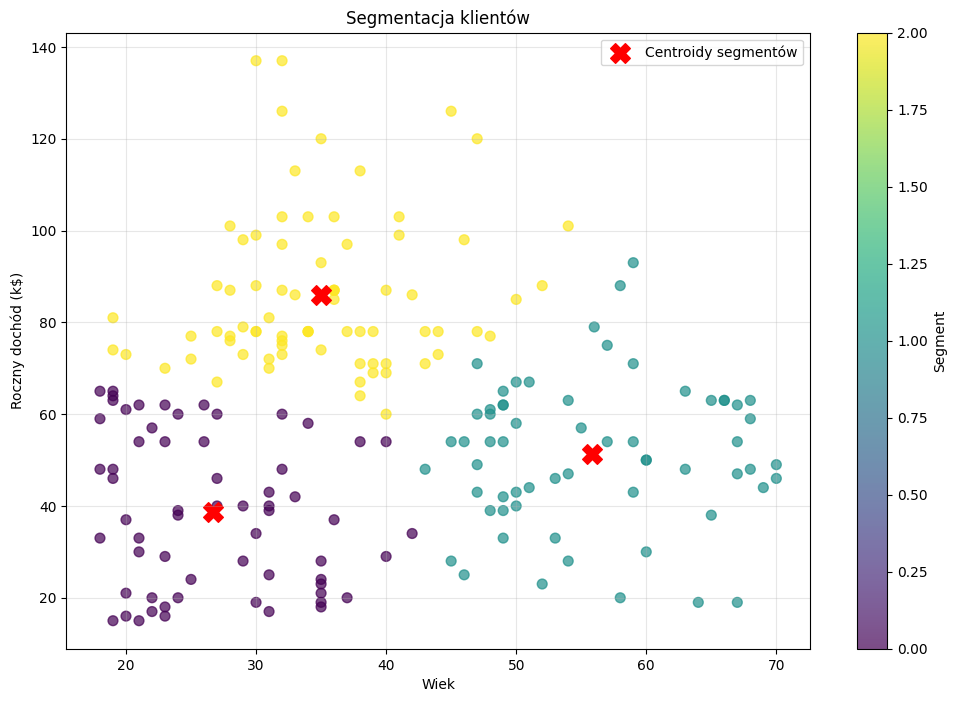

In [20]:
kmeans_customers = KMeans(n_clusters=3, random_state=random_state, n_init=10)
customer_segments = kmeans_customers.fit_predict(X_scaled)

df_clients['Segment'] = customer_segments

centroids_original = scaler.inverse_transform(kmeans_customers.cluster_centers_)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_features[:, 0], X_features[:, 1], c=customer_segments, cmap='viridis', s=50, alpha=0.7)
plt.scatter(centroids_original[:, 0], centroids_original[:, 1], c='red', s=200, marker='X', label='Centroidy segmentów')

plt.xlabel('Wiek')
plt.ylabel('Roczny dochód (k$)')
plt.title(f'Segmentacja klientów')
plt.colorbar(scatter, label='Segment')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
segments_summary = []

for segment in range(3):
    segment_data = df_clients[df_clients['Segment'] == segment]
    
    age_mean = segment_data['Age'].mean()
    income_mean = segment_data['Annual Income (k$)'].mean()
    score_mean = segment_data['Spending Score (1-100)'].mean()

    segments_summary.append({
        "Segment": segment,
        "Liczba klientów": len(segment_data),
        "Udział (%)": round(len(segment_data)/len(df_clients)*100, 1),
        "Średni wiek": round(age_mean, 1),
        "Średni dochód (k$)": round(income_mean, 1),
        "Średni score": round(score_mean, 1),
    })

pd.DataFrame(segments_summary)

,Segment,Liczba klientów,Udział (%),Średni wiek,Średni dochód (k$),Średni score
0,0,62,31.0,26.7,38.8,56.8
1,1,62,31.0,55.8,51.2,39.7
2,2,76,38.0,35.0,85.9,53.4


Pogrupowanych klientów według cech, może możnaby określić jako:
- klaster 0: młodzi, niski dochód
- klaster 1: starsi, średni dochór
- klaster 2: kryzys wieku średniego, wysoki dochód

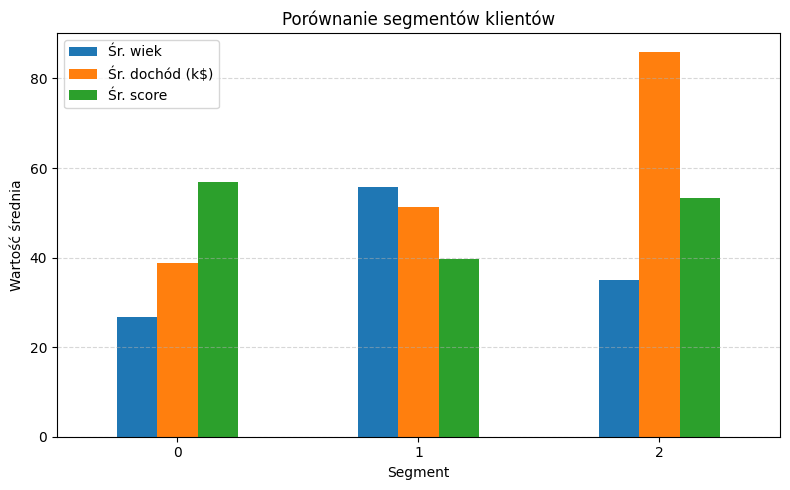

In [24]:
pd.DataFrame(segments_summary).plot(
    x="Segment",
    y=["Śr. wiek", "Śr. dochód (k$)", "Śr. score"],
    kind="bar",
    figsize=(8, 5),
    title="Porównanie segmentów klientów",
)

plt.ylabel("Wartość średnia")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()